# Distributed processing for graph creation (optimized)

In [1]:
import readfof
from pyspark.sql import SparkSession
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
spark = SparkSession.builder \
        .master("spark://master:7077")\
        .appName("CosmoSparkApplication")\
        .getOrCreate()

sc = spark.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/10 14:25:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Read data
def read_cosmo_data(file_path):

    # Read Fof
    FoF = readfof.FoF_catalog(
        file_path,           # simulation directory
        2,                   # snapnum, indicating the redshift (z=1)
        long_ids = False,
        swap = False,
        SFR = False,
        read_IDs = False
        )

    return FoF


# Get masses and positions from FoF
def get_pos_mass(FoF):

    pos = FoF.GroupPos/1e06             # Halo positions in Gpc/h 
    mass_raw = FoF.GroupMass * 1e10     # Halo masses in Msun/h

    dim = pos.shape[0]
    pos_mass_matrix = np.hstack([pos, mass_raw.reshape(dim, 1)])

    return pos_mass_matrix

# To assign simulation keys to each point in each simulation
def assign_key_to_rows(key_value_pair):
    key, array = key_value_pair
    return [(key, row) for row in array]


# To assign each value of the rdd to each bin
def bin_placer(value, edges):
    for i in range(1, len(edges)):
        if value < edges[i]:
            return edges[i - 1]
    return edges[-1]


# Plot a graph in 3D space
def plot_graph_3D(num, pars_file, pos, masses, edge_idx):

    fig = plt.figure(figsize=(10, 10))
    fontsize = 12

    ax = fig.add_subplot(projection ="3d")

    pos = np.array(pos, dtype=float) * 1.e3   # show in Mpc

    # Draw lines for each edge
    for (src, dst) in edge_idx: #.t().tolist():

        src = pos[int(src)].tolist()
        dst = pos[int(dst)].tolist()

        ax.plot([src[0], dst[0]], [src[1], dst[1]], zs=[src[2], dst[2]], linewidth=0.6, color='dimgrey')

    # Plot nodes
    mass_mean = np.mean(masses)
    for i,m in enumerate(masses):
            ax.scatter(pos[i, 0], pos[i, 1], pos[i, 2], s=50*m*m/(mass_mean**2), zorder=1000, alpha=0.6, color = 'mediumpurple')

    ax.xaxis.set_tick_params(labelsize=fontsize)
    ax.yaxis.set_tick_params(labelsize=fontsize)
    ax.zaxis.set_tick_params(labelsize=fontsize)

    ax.set_xlabel('x (Mpc)', fontsize=16, labelpad=15)
    ax.set_ylabel('y (Mpc)', fontsize=16, labelpad=15)
    ax.set_zlabel('z (Mpc)', fontsize=16, labelpad=15)

    rl = '$R_{link} = 0.2$'

    pars_file = pars_file[num]

    ax.set_title(f'\tGraph n°{num}, Masses $\\geq 99.7$% percentile, {rl} Mpc \t \n \n $\\Omega_m = {float(pars_file[0]):.3f}$ \t $\\sigma_8 = {float(pars_file[1]):.3f}$', fontsize=20)

    plt.show()


# Graph object
class graph:

    def __init__(self, node_f, pos, sim_pars, glob_f, edge_idx, edge_f):
        
        self.node_f = node_f
        self.pos = pos
        self.sim_pars = sim_pars
        self.glob_f = glob_f
        self.edge_idx = edge_idx
        self.edge_f = edge_f


# Create graph object
def create_graph(element):
    sim_graph = graph(
        np.array(element[0])[:,3],   # node_f = masses
        np.array(element[0])[:,0:3], # pos
        np.array(element[3]),        # sim_pars
        np.array(element[2]),        # glob_f
        np.array(element[1])[:,0:2], # edge_idx
        np.array(element[1])[:,2:5], # edge_f
    )
    return(sim_graph)


# Function that returns the partitions bounds as a dictionary of lists of tuples, 
# each tuple being the min and max of a dimension
def sub_box_bounds(box_number,r_link): 
    sub_length=1.0/box_number # partition length
    bounds={}
    base='box'
    sub_box_counter=1
    for x in range(0,box_number):
        for y in range(0,box_number):
            for z in range(0,box_number):
                key=base+str(sub_box_counter)
                single_bounds=[]
                centre=[x,y,z] # vertex of a sub_box corresponding to min x,y,z
                for i in range(3):
                    min_bound=round(max(0,centre[i]*sub_length-0.5*r_link),2)
                    max_bound=round(min(1,centre[i]*sub_length+sub_length+0.5*r_link),2)
                    single_bounds.append((min_bound,max_bound))
                bounds[key]=single_bounds
                sub_box_counter+=1

    return bounds

# Assign each point to a box
def assign_box(point, boxes):
    position = point[1]
    x, y, z = position
    box_assign = []
    
    for box_name, ((x_min, x_max), (y_min, y_max), (z_min, z_max)) in boxes.items():
     if (x_min <= x <= x_max) and (y_min <= y <= y_max) and (z_min <= z <= z_max):
           box_assign.append((box_name, point))
    
    return box_assign

# Convert all element of an rdd into a tuple
def convert_to_tuple(data):
    return (
        data[0],
        data[1][0],
        data[1][1],
        (float(data[1][2][0]), float(data[1][2][1]), float(data[1][2][2])),  # from array to tuple
        (float(data[1][3][0]), float(data[1][3][1]), float(data[1][3][2])),  # from array to tuple
        (float(data[1][4][0]), float(data[1][4][1]), float(data[1][4][2])),  # from array to tuple
        float(data[1][5])           
        
    )

# Convert vectors of an rdd into a np.array (key, ( ...)) 
def convert_to_array(data):
    return (
        data[0],
        (
            data[1],
            data[2],
            np.array([float(data[3][0]), float(data[3][1]), float(data[3][2])]),  # from tuple to array
            np.array([float(data[4][0]), float(data[4][1]), float(data[4][2])]),  # from tuple to array
            np.array([float(data[5][0]), float(data[5][1]), float(data[5][2])]),  # from tuple to array
            float(data[6]) # to standard float
        )
    )

In [4]:
# simulations parameter
sim_pars_file = np.loadtxt("/mnt/cosmo_GNN/latin_hypercube_params.txt", dtype=float)

# number of simulations to be processed
n_sims = 1000

# path list with simulation keys
path_list = [(i, "/mnt/cosmo_GNN/Data/" + str(i)) for i in range(n_sims)]

# parallelize path list and read files
fof_rdd = sc.parallelize(path_list)\
            .mapValues(read_cosmo_data)

# get positions and masses for each point
pos_mass_rdd = fof_rdd.mapValues(get_pos_mass)\
                      .flatMap(assign_key_to_rows)

# cut percentile
cut = 0.997

# get mass cuts 
mass_cut_rdd = fof_rdd.mapValues(get_pos_mass)\
                      .mapValues(lambda x: np.quantile(x[:, -1], cut))

In [5]:
# mass cuts distribution histogram

# bin edges 
min_mass_cuts = mass_cut_rdd.map(lambda x: x[1]).reduce(min)
max_mass_cuts = mass_cut_rdd.map(lambda x: x[1]).reduce(max)

# number of bins
num_bins = int(1 + np.log2(n_sims)) # Sturges's rule

# bin width
bin_width = (max_mass_cuts - min_mass_cuts) / num_bins

# edges
edges = [min_mass_cuts + i * bin_width for i in range(int(num_bins) + 1)]

# histogram with map - reduce
mapped_mass_cuts = mass_cut_rdd.map(lambda x: (bin_placer(x[1], edges), 1))
reduced_mass_cuts = mapped_mass_cuts.reduceByKey(lambda x, y: x + y)
mass_cuts_distr = np.array(reduced_mass_cuts.collect())

In [10]:
bin_width = (max_mass_cuts - min_mass_cuts) / 11

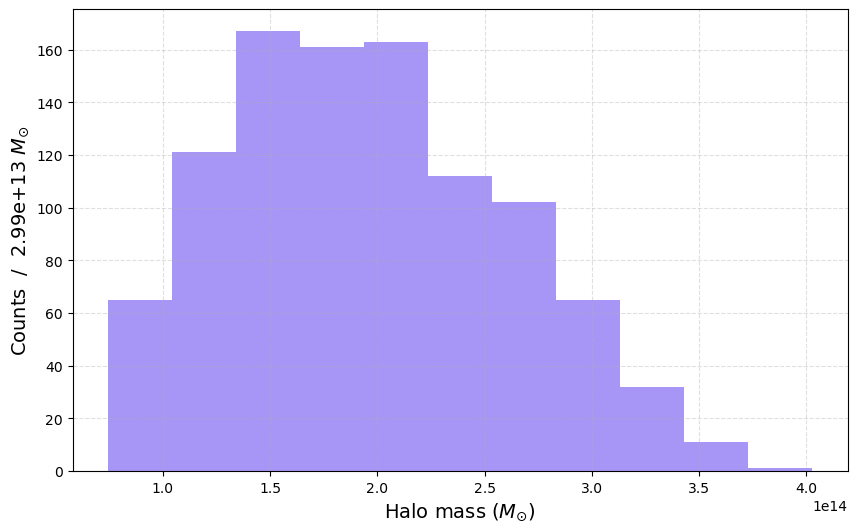

In [11]:
fig, ax = plt.subplots(figsize=(10,6))

ax.hist(mass_cuts_distr[:, 0], bins=11, weights=mass_cuts_distr[:, 1], color='#785EF0', alpha=0.65, label='Mass distribution')
ax.set_xlabel('Halo mass ($M_{\\odot}$)', fontsize=14)
modot = '$M_{\\odot}$'
b_width = "{:.2e}".format(bin_width)
ax.set_ylabel(f'Counts  /  {b_width} ' + modot, fontsize=14)
ax.grid(alpha=0.4, linestyle='--')


In [12]:
## con il join più veloce ?

# collect mass cuts into numpy array
mass_cuts = mass_cut_rdd.values().collect()
mass_cuts = np.array(mass_cuts)

# filter by mass
pos_mass_rdd_filtered = pos_mass_rdd.filter(lambda x: x[1][-1] >= mass_cuts[x[0]])

# number of halos in each simulation
n_halos = pos_mass_rdd_filtered.countByKey()

In [15]:
n_halos_rdd = sc.parallelize(n_halos.values())

In [18]:
n_halos_rdd.take(10)

[188, 641, 248, 517, 449, 681, 220, 222, 478, 179]

In [22]:
# number of halos distribution histogram

# bin edges 
min_n_halos = n_halos_rdd.map(lambda x: x).reduce(min)
max_n_halos = n_halos_rdd.map(lambda x: x).reduce(max)

# number of bins
num_bins_halos = int(1 + np.log2(n_sims)) # Sturges's rule

# bin width
bin_width_halos = (max_n_halos - min_n_halos) / num_bins_halos

# edges
edges_halos = [min_n_halos + i * bin_width_halos for i in range(num_bins_halos + 1)]

# histogram with map - reduce
mapped_n_halos = n_halos_rdd.map(lambda x: (bin_placer(x, edges_halos), 1))
reduced_n_halos = mapped_n_halos.reduceByKey(lambda x, y: x + y)
n_halos_distr = np.array(reduced_n_halos.collect())

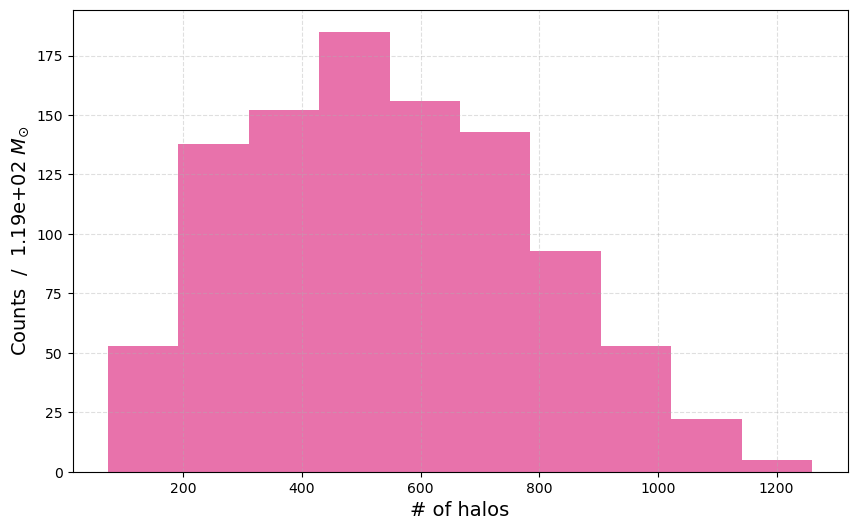

In [25]:
fig1, ax1 = plt.subplots(figsize=(10,6))

ax1.hist(n_halos_distr[:, 0], bins=num_bins_halos, weights=n_halos_distr[:, 1], color='#DC267F', alpha=0.65, label='Mass distribution')
ax1.set_xlabel('# of halos', fontsize=14)
b_width = "{:.2e}".format(bin_width_halos)
ax1.set_ylabel(f'Counts  /  {b_width} ' + modot, fontsize=14)
ax1.grid(alpha=0.4, linestyle='--')

In [26]:
boxes = sub_box_bounds(4,0.2)

In [9]:
# masses rdd ---> (simkey, mass)
mass_rdd = pos_mass_rdd_filtered.mapValues(lambda x: x[3])

# positions rdd ---> (simkey, pos)
pos_rdd = pos_mass_rdd_filtered.mapValues(lambda x: x[:3])

# indexed positions rdd (point indexes)
# --> ( simkey, (point_idx, array(x, y, z)) )
idx_pos_rdd = pos_rdd.groupByKey()\
                     .flatMapValues(lambda vals: enumerate(vals))

# indexed positions rdd with box assigned
# --> ( simkey_boxkey, (point_idx, array(x, y, z)) )
idx_pos_box_rdd = idx_pos_rdd.flatMapValues(lambda p: assign_box(p, boxes))\
                             .map(lambda x: (str(x[0]) + '_' + x[1][0], x[1][1]))

# obtain all the possible point pairs for each simulation clustered by boxes
# --> ( (simkey_boxkey, (idx, array)), (simkey_boxkey, (idx, array)) )
cartesian_rdd = idx_pos_box_rdd.groupByKey()\
                        .flatMapValues(lambda points: [(p1,p2) for p1 in points for p2 in points])\
                        .map(lambda x: ((x[0], x[1][0]),(x[0], x[1][1])))

# compute differences between every pair 
# --> (simkey_boxkey, (idx1, idx2, coord1, coord2, diff_coord))
diff_rdd = cartesian_rdd.map(lambda x:(x[0][0],(x[0][1][0], x[1][1][0], x[0][1][1],  x[1][1][1] , x[0][1][1] - x[1][1][1])))

# --> (simkey_boxkey, (idx1, idx2, coord1, coord2, diff_coord, norm))
pairs_dist_rdd_with_box = diff_rdd.mapValues(lambda x: (x[0], x[1], x[2], x[3], x[4], np.linalg.norm(x[4])))

pairs_dist_rdd_no_box = pairs_dist_rdd_with_box.map(lambda x: (int(x[0].split('_')[0]), (x[1])))\
                                               .map(convert_to_tuple)\
                                               .distinct()\
                                               .map(convert_to_array)

# pairs and distances rdd filtered (linking radius):
# take pairs_dist_rdd_with_box
# filter by linking radius
# consider only sim_key
# take unique elements (convertion tuple-array due to type reasons)
# ---> (sim_key, (idx1, idx2, coord1, coord2, diff_coord, norm )
# linked_pairs_dist_rdd = pairs_dist_rdd_with_box.filter(lambda x: x[1][5] < 0.2)\
#                                                 .map(lambda x: (int(x[0].split('_')[0]), (x[1])))\
#                                                 .map(convert_to_tuple)\
#                                                 .distinct()\
#                                                 .map(convert_to_array)
linked_pairs_dist_rdd = pairs_dist_rdd_no_box.filter(lambda x: x[1][-1] <= 0.2)

# pairs rdd --> (simkey, (idx1, idx2)) --> reverse pair already included
pairs_rdd = linked_pairs_dist_rdd.mapValues(lambda x: (x[0], x[1]))

In [10]:
pairs_dist_rdd_no_box.countByKey()

defaultdict(int,
            {0: 5144,
             5: 65205,
             2: 8698,
             7: 7124,
             3: 45301,
             8: 35608,
             1: 59099,
             4: 30927,
             6: 6984,
             9: 4973})

In [11]:
linked_pairs_dist_rdd.countByKey()

defaultdict(int,
            {1: 11787,
             4: 7109,
             6: 1474,
             9: 1077,
             2: 2110,
             7: 1724,
             3: 8035,
             8: 6734,
             0: 1224,
             5: 12977})

In [12]:
# retrieve data for a simulation to show the plot
sim_num_plot = 8
pos_mass_rdd_filtered_plot = pos_mass_rdd_filtered.filter(lambda x: x[0] == sim_num_plot)\
                                                  .map(lambda x: x[1])
pos_mass_plot = np.array(pos_mass_rdd_filtered_plot.collect())
pos_plot = pos_mass_plot[:,:3]
mass_plot = pos_mass_plot[:,3]
pairs_idx_plot = pairs_rdd.filter(lambda x: x[0] == sim_num_plot)\
                          .values()
pairs_idx_plot_array = np.array(pairs_idx_plot.collect())

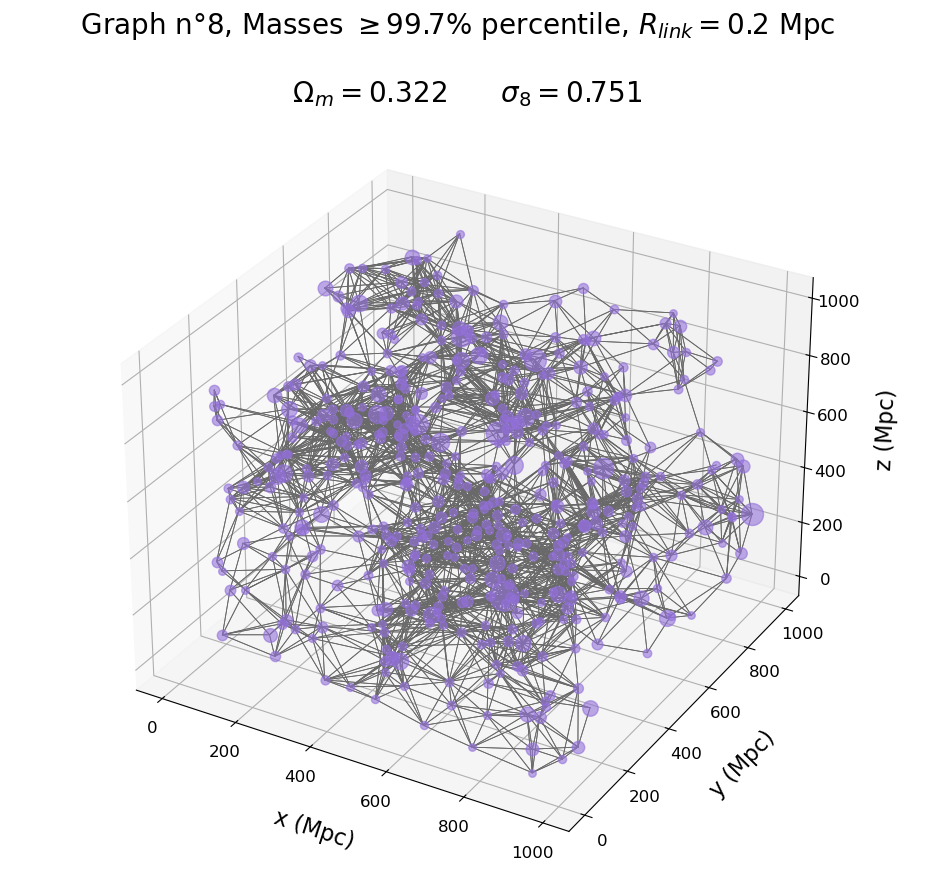

In [38]:
plot_graph_3D(sim_num_plot, sim_pars_file, pos_plot, mass_plot, pairs_idx_plot_array)

In [13]:
# centroids positions
halo_centroids = pos_rdd.reduceByKey(lambda x,y: (x+y)/2)

# joined rdd with halo centroids positions
joined_rdd = linked_pairs_dist_rdd.join(halo_centroids)

# distance between each point from each pair and halo centroid
row_col_diff_rdd = joined_rdd.mapValues(
    lambda x: (
        x[0][0],        # idx_i
        x[0][1],        # idx_j
        x[0][2] - x[1], # row
        x[0][3] - x[1], # col
        x[0][4],        # diff
        x[0][5]         # dist
        ))

# normalizing 
normalized_rdd = row_col_diff_rdd.mapValues(
    lambda x: (
        x[0],                      # idx_i
        x[1],                      # idx_j
        x[2]/np.linalg.norm(x[2]), # row_normalized
        x[3]/np.linalg.norm(x[3]), # col_normalized
        x[4]/np.linalg.norm(x[4]), # s_ij
        x[5]/0.2                   # |d_ij|/r 
    )
)

# edge attributes
edge_attr_rdd = normalized_rdd.mapValues(
    lambda x: (
        x[0],
        x[1],
        np.dot( x[2].T, x[3] ), # cos(alpha)
        np.dot( x[2].T, x[4] ), # cos(beta)
        x[5]                    # |d_ij|/r 
    )
)

In [14]:
# group by simulation
grouped_idx_pos_rdd = pos_mass_rdd_filtered.groupByKey()\
                                 .mapValues(list)

grouped_edge_rdd = edge_attr_rdd.groupByKey()\
                                .mapValues(list)

# parallelize simulation parameters file and global features
param_rdd = sc.parallelize([(i, el) for i, el in enumerate(sim_pars_file)])
u = sc.parallelize([(i[0], math.log10(i[1])) for i in n_halos.items()])

# graph rdd (a graph for each simulation)
# masses, positions, simulation parameters, global features, edge indexes, edge features
raw_graph_rdd = grouped_idx_pos_rdd.join(grouped_edge_rdd)\
                                   .join(u)\
                                   .join(param_rdd)\
                                   .mapValues(lambda x: (x[0][0][0], x[0][0][1], x[0][1], x[1]))

graph_rdd = raw_graph_rdd.mapValues(lambda x: create_graph(x))   


In [15]:
graph_rdd.count()

10

In [16]:
graph_rdd.getNumPartitions()

80

In [17]:
graph_rdd.collect()

[(0, <__main__.graph at 0x7f82d4c55790>),
 (1, <__main__.graph at 0x7f82d4c2d1f0>),
 (2, <__main__.graph at 0x7f82d4c2e780>),
 (3, <__main__.graph at 0x7f82d4c2fc20>),
 (4, <__main__.graph at 0x7f82d4c2e420>),
 (5, <__main__.graph at 0x7f82d4c2ddc0>),
 (6, <__main__.graph at 0x7f82d4c577d0>),
 (7, <__main__.graph at 0x7f82d4c2d850>),
 (8, <__main__.graph at 0x7f82d4c2f290>),
 (9, <__main__.graph at 0x7f82d4c2ed50>)]

In [18]:
graph_rdd.take(10)[8][1].node_f

array([7.2134815e+14, 5.5314266e+14, 5.4184032e+14, 5.3918093e+14,
       5.0793317e+14, 4.9929032e+14, 4.8399819e+14, 4.5141975e+14,
       4.3613017e+14, 4.3413563e+14, 4.3214109e+14, 4.2615749e+14,
       4.1352546e+14, 4.0754186e+14, 4.0288796e+14, 4.0089312e+14,
       3.9490983e+14, 3.9158552e+14, 3.9158562e+14, 3.8959108e+14,
       3.8759657e+14, 3.8626688e+14, 3.8560139e+14, 3.8094813e+14,
       3.7496454e+14, 3.7429969e+14, 3.7164030e+14, 3.6831609e+14,
       3.6831609e+14, 3.6565670e+14, 3.6432704e+14, 3.6299859e+14,
       3.6233250e+14, 3.6033796e+14, 3.5967311e+14, 3.5967311e+14,
       3.5834345e+14, 3.5568406e+14, 3.5169501e+14, 3.4438172e+14,
       3.4371687e+14, 3.4172233e+14, 3.3906297e+14, 3.3906297e+14,
       3.3573873e+14, 3.2443649e+14, 3.2377168e+14, 3.2377168e+14,
       3.2310687e+14, 3.2111239e+14, 3.1911792e+14, 3.1845310e+14,
       3.1180483e+14, 3.1180483e+14, 3.1180489e+14, 3.0981039e+14,
       3.0848076e+14, 3.0781591e+14, 3.0715106e+14, 3.0582237e

In [22]:
sc.stop()
spark.stop()